In [1]:
import sys
sys.path.append('..')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import diffrax
import flax
import IPython.display as ipd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import seaborn as sns
from score_flow import sde_lib
import tensorflow_probability.substrates.jax as tfp

import probability_flow
from posterior_sampling import realnvp_model
from posterior_sampling import model_utils as mutils

sns.set(font='serif', font_scale=1.5)
tfd = tfp.distributions

2024-03-03 12:53:17.257474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Posterior Sampling with Score-based Priors: 2D Example

## Ground-truth posterior

In this example, we will work with a mixture-of-Gaussians prior and a linear forward model. The resulting posterior is also a mixture-of-Gaussians.

**Prior:** $\mathbf{x}\sim\sum_{k=1}^K\mathcal{N}(\mathbf{\mu}_k,\beta_k^2\mathbf{I}_2)$

**Likelihood:** $y=\mathbf{a^\intercal x}+\eta,\quad\eta\sim\mathcal{N}(0,\sigma^2)$

In [2]:
"""
The prior is a mixture-of-Gaussians with K Gaussian components.
Each component has a weight, mean, and diagonal covariance with uniform scale.
You can change these parameters to see how the posterior changes.
"""
means = np.array(
    [[-0.5, -0.5],
    [0.5, 0.5]]
).astype(np.float32)
betas = np.array([0.1, 0.1], dtype=np.float32)
weights = np.array([0.5, 0.5], dtype=np.float32)
K = len(weights)
prior = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=means,
        scale_diag=jnp.stack([jnp.ones(2) * b for b in betas], axis=0))
)

In [3]:
"""
The measurement is a linear projection of x with Gaussian noise.
This means p(y|x) is also Gaussian.
"""
sigma = 0.2  # std. dev. of measurement noise
a = np.array([-2., 1.7], dtype=np.float32)  # forward operator
y = 0.3  # observation

likelihood = lambda x: tfd.Normal(loc=jnp.dot(a, x), scale=sigma)

def prob_y(y):
  stds = jnp.sqrt(betas**2 * jnp.dot(a, a) + sigma**2)
  dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=weights),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=jnp.einsum('j,bj->b', a, means)[:, None],
        scale_diag=stds[:, None]))
  return dist.prob(y)

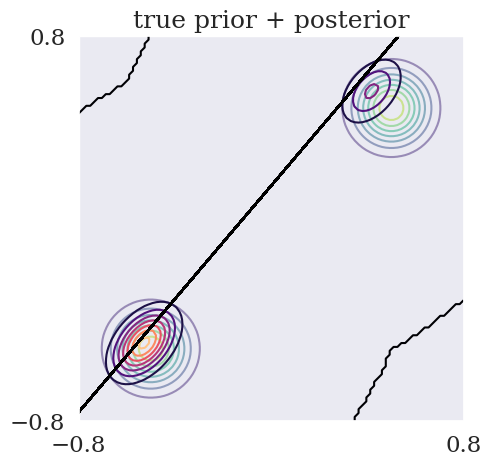

In [4]:
"""
With the prior and likelihood defined, we also know the posterior.
"""
# Posterior p(x|y)
@jax.vmap
def posterior_prob(x, y):
  py = prob_y(y)
  px = prior.prob(x)
  return likelihood(x).prob(y) * px / py

# Parameters for plotting
x1_range = (-0.8, 0.8)
x2_range = (-0.8, 0.8)

# Domain
x1_grid, x2_grid = np.meshgrid(
    np.linspace(*x1_range, 100), np.linspace(*x2_range, 100))
x1_flattened = x1_grid.reshape(-1)
x2_flattened = x2_grid.reshape(-1)
X = np.stack([x1_flattened, x2_flattened], axis=-1)

# True prior PDF
prior_grid = prior.prob(X).reshape(100, 100)

# True posterior PDF
Y = np.full(X.shape[0], y).astype(np.float32)
posterior_grid = posterior_prob(X, Y).reshape(100, 100)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
ax.set_xlim(*x1_range); ax.set_ylim(*x2_range)
ax.set_xticks(x1_range); ax.set_yticks(x2_range)
ax.contour(x1_grid, x2_grid, prior_grid, cmap='viridis', alpha=0.5)
ax.contour(x1_grid, x2_grid, posterior_grid, cmap='magma')
ax.plot(x1_flattened, y / a[1] - x1_flattened * (a[0] / a[1]),
         linestyle='--', c='black')
plt.title('true prior + posterior')
plt.show()

## DPI Posterior Sampling

The DPI optimization objective is
\begin{align*}
\phi^* &= \arg\min_\phi D_{\text{KL}}(q_\phi\lVert p(\cdot\mid y) \\
&= \arg\min_\phi \mathbb{E}_{\mathbf{x}\sim q_\phi}[-\log p(y\mid\mathbf{x})-\log p(\mathbf{x})+\log q_\phi(\mathbf{x})],
\end{align*}
where $\phi$ are the parameters of a RealNVP normalizing flow. Of course, we could directly use the known prior $p(\mathbf{x})$. However, for demonstration purposes, we will assume that we only have access to the time-dependent score function $\nabla_\mathbf{x} \log p_t(\mathbf{x})$, where

\begin{align*}
p_t(\mathbf{x})=\sum_{k=1}^K\mathcal{N}(\mathbf{x}; \alpha(t)\mu_k, \alpha(t)^2\beta_k^2+\beta(t)^2).
\end{align*}
$\alpha(t)$ and $\beta(t)$ are scalars determined by the diffusion SDE. To calculate $\log p(\mathbf{x})$ with only the score function, we can use the probability flow ODE as proposed in the paper.

In [5]:
"""
The SDE dictates how the prior distribution changes over diffusion time
and hence the probability flow ODE used to evaluate logp(x).
"""
sde = sde_lib.VPSDE()
t0_eps = 1e-12  # smallest time for numerical stability

def marginal_dist_params(t: float):
  """The mean coefficient and std. dev. of the marginal distribution at t."""
  all_ones = jnp.ones((1, 1))
  t_batch = jnp.ones(1) * t
  mean, std = sde.marginal_prob(all_ones, t_batch)
  alpha_t = mean[0][0]
  beta_t = std[0]
  return alpha_t, beta_t

def score_fn(x, t_batch):
  def _unnormalized_log_prob(data, t):
    alpha_t, beta_t = marginal_dist_params(t)
    var_t = alpha_t**2 * betas**2 + beta_t**2
    means_t = alpha_t * means
    norm2 = jnp.linalg.norm(data - means_t, axis=-1)**2
    return jax.scipy.special.logsumexp(-0.5 * norm2 / var_t)
  return jax.vmap(jax.grad(lambda xi, ti: _unnormalized_log_prob(xi, ti)))(x, t_batch)

# `prob_flow` is a wrapper for the probability flow ODE.
prob_flow = probability_flow.ProbabilityFlow(
  sde=sde,
  score_fn=score_fn,
  solver=diffrax.Dopri5(),
  stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5),
  adjoint=diffrax.RecursiveCheckpointAdjoint(),
  n_trace_estimates=-1)

In [6]:
"""
Here we set up the RealNVP that we wish to optimize.
"""
batch_size = 2560
learning_rate = 1e-5

dim = 2  # data dimensionality (2 in this case)
n_flow = 8  # number flow layers (each layer has 2 affine-coupling layers)

orders, reverse_orders = realnvp_model.get_orders(dim, n_flow)
model = realnvp_model.RealNVP(
    out_dim=dim,
    n_flow=n_flow,
    orders=orders,
    reverse_orders=reverse_orders,
    seqfrac=1/128,
    include_softplus=False,
    init_softplus_log_scale=1,
    train=True)

# Initialize params and model state.
init_rng = jax.random.PRNGKey(42)
z = jax.random.normal(init_rng, (batch_size, dim))
variables = model.init(init_rng, z, reverse=True)
init_model_state, init_params = flax.core.pop(variables, 'params')

# Initialize optimizer.
optimizer = optax.adam(learning_rate=learning_rate)

# Initialize training state.
opt_state = optimizer.init(init_params)
state = mutils.State(
    step=0,
    opt_state=opt_state,
    params=init_params,
    model_state=init_model_state,
    entropy_weight=1,
    rng=jax.random.PRNGKey(0)
)

In [7]:
"""
Here we define the optimization objective function and update step for the RealNVP.
"""
@jax.vmap
def data_loss_fn(x):
  return -likelihood(x).log_prob(Y)

def prior_loss_fn(rng, x):
  return -prob_flow.logp_fn(rng, x, t0=t0_eps, t1=sde.T, dt0=None)

def get_sampling_fn(model, params, states, train=False):
  def sample_fn(rng, shape):
    # Sample latent.
    z = jax.random.normal(rng, shape)

    variables = {'params': params, **states}
    if train:
      (samples, logdet), new_states = model.apply(
          variables, z, reverse=True, mutable=list(states.keys()))
    else:
      samples, logdet = model.apply(variables, z, reverse=True, mutable=False)
      new_states = states
    return (samples, logdet), new_states
  return sample_fn

def loss_fn(rng, params, model_state, lambda_entropy):
  sample_fn = get_sampling_fn(model, params, model_state, train=True)

  # Sample from the current state of the RealNVP.
  rng, step_rng = jax.random.split(rng)
  (samples, logdet), new_model_state = sample_fn(step_rng, (batch_size, dim))

  # Compute loss across this batch of samples.
  loss_data = data_loss_fn(samples)
  rng, step_rng = jax.random.split(rng)
  loss_prior = prior_loss_fn(step_rng, samples)
  loss_entropy = -lambda_entropy * logdet

  loss_data = jnp.mean(loss_data)
  loss_prior = jnp.mean(loss_prior)
  loss_entropy = jnp.mean(loss_entropy)
  loss = loss_data + loss_prior + loss_entropy

  return loss, (new_model_state, loss_data, loss_prior, loss_entropy, samples)

def step_fn(rng, state):
  val_and_grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)

  params = state.params
  model_state = state.model_state
  opt_state = state.opt_state
  (loss, (new_model_state, loss_data, loss_prior, loss_entropy, samples)), grad = val_and_grad_fn(
      rng, params, model_state, lambda_entropy=state.entropy_weight)

  # Apply updates.
  updates, new_opt_state = optimizer.update(grad, opt_state, params)
  new_params = optax.apply_updates(params, updates)

  step = state.step + 1
  new_state = state.replace(
      step=step,
      opt_state=new_opt_state,
      params=new_params,
      model_state=new_model_state,
  )

  return new_state, (loss, loss_data, loss_prior, loss_entropy), samples

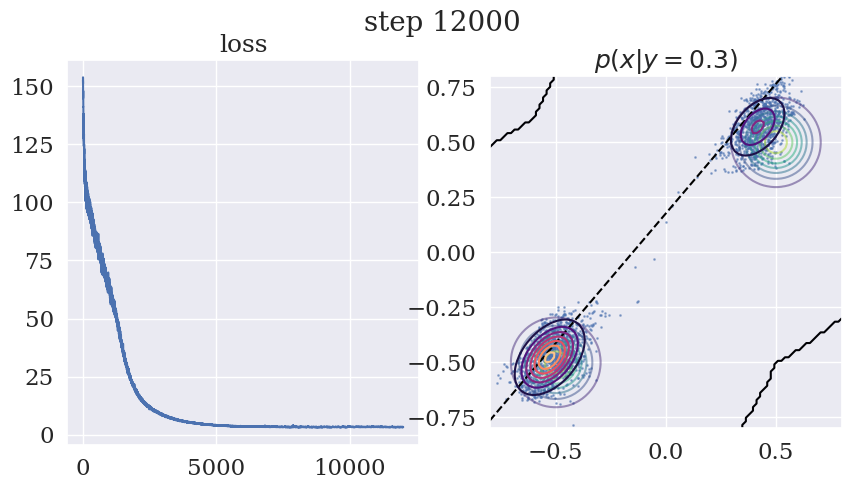

In [8]:
"""
We iteratively sample from the RealNVP, estimate its KL divergence to the target posterior,
and update the RealNVP parameters with gradients to minimize the KL divergence.
"""
losses_total, losses_data, losses_prior, losses_entropy = [], [], [], []
train_step = jax.jit(step_fn)

init_step = state.step
rng = state.rng
for step in range(init_step, 12001):
  rng, step_rng = jax.random.split(rng)
  state, (loss, loss_data, loss_prior, loss_entropy), samples = train_step(
      step_rng, state)

  # Update losses.
  losses_total.append(loss)
  losses_data.append(loss_data)
  losses_prior.append(loss_prior)
  losses_entropy.append(loss_entropy)

  if step % 10 == 0:
    ipd.clear_output(wait=True)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'step {step}', fontsize=20)

    ax = axs[0]
    ax.plot(losses_total); ax.set_title('loss', fontsize=18)

    ax = axs[1]
    ax.set_aspect('equal')
    ax.set_xlim(*x1_range); ax.set_ylim(*x2_range)
    ax.plot(x1_flattened, y / a[1] - x1_flattened * (a[0] / a[1]),
            linestyle='--', c='black')
    ax.contour(x1_grid, x2_grid, prior_grid, alpha=0.5, cmap='viridis')
    ax.contour(x1_grid, x2_grid, posterior_grid, cmap='magma')
    ax.scatter(
        samples[:, 0], samples[:, 1],
        s=1, alpha=0.5, label='DPI samples')
    plt.title(f'$p(x|y={y})$')
    plt.show()